In [1]:
import random
import numpy as np
import torch
import anndata
import bottleneck

from neuralee.embedding import NeuralEE
from neuralee.dataset import GeneExpressionDataset
from neuralee._aux import scatter

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(1234)
random.seed(1234)
np.random.seed(1234)

In [2]:
adata = anndata.read_h5ad('../data/genomics_zheng17_50pcs.h5ad')
brain_dataset = GeneExpressionDataset(adata.X)
brain_dataset.affinity_split(N_small=5000, perplexity=30.0, verbose=True)  

Compute affinity, perplexity=30.0, N_small=5000, on each batch
affinity on each batch: 100%|██████████| 261/261 [21:27<00:00,  4.94s/it]


NeuralEE: 100%|██████████| 50/50 [08:36<00:00, 10.33s/it]
Neural Elastic Embedding, lambda=1000.0, completed in 518.67s.


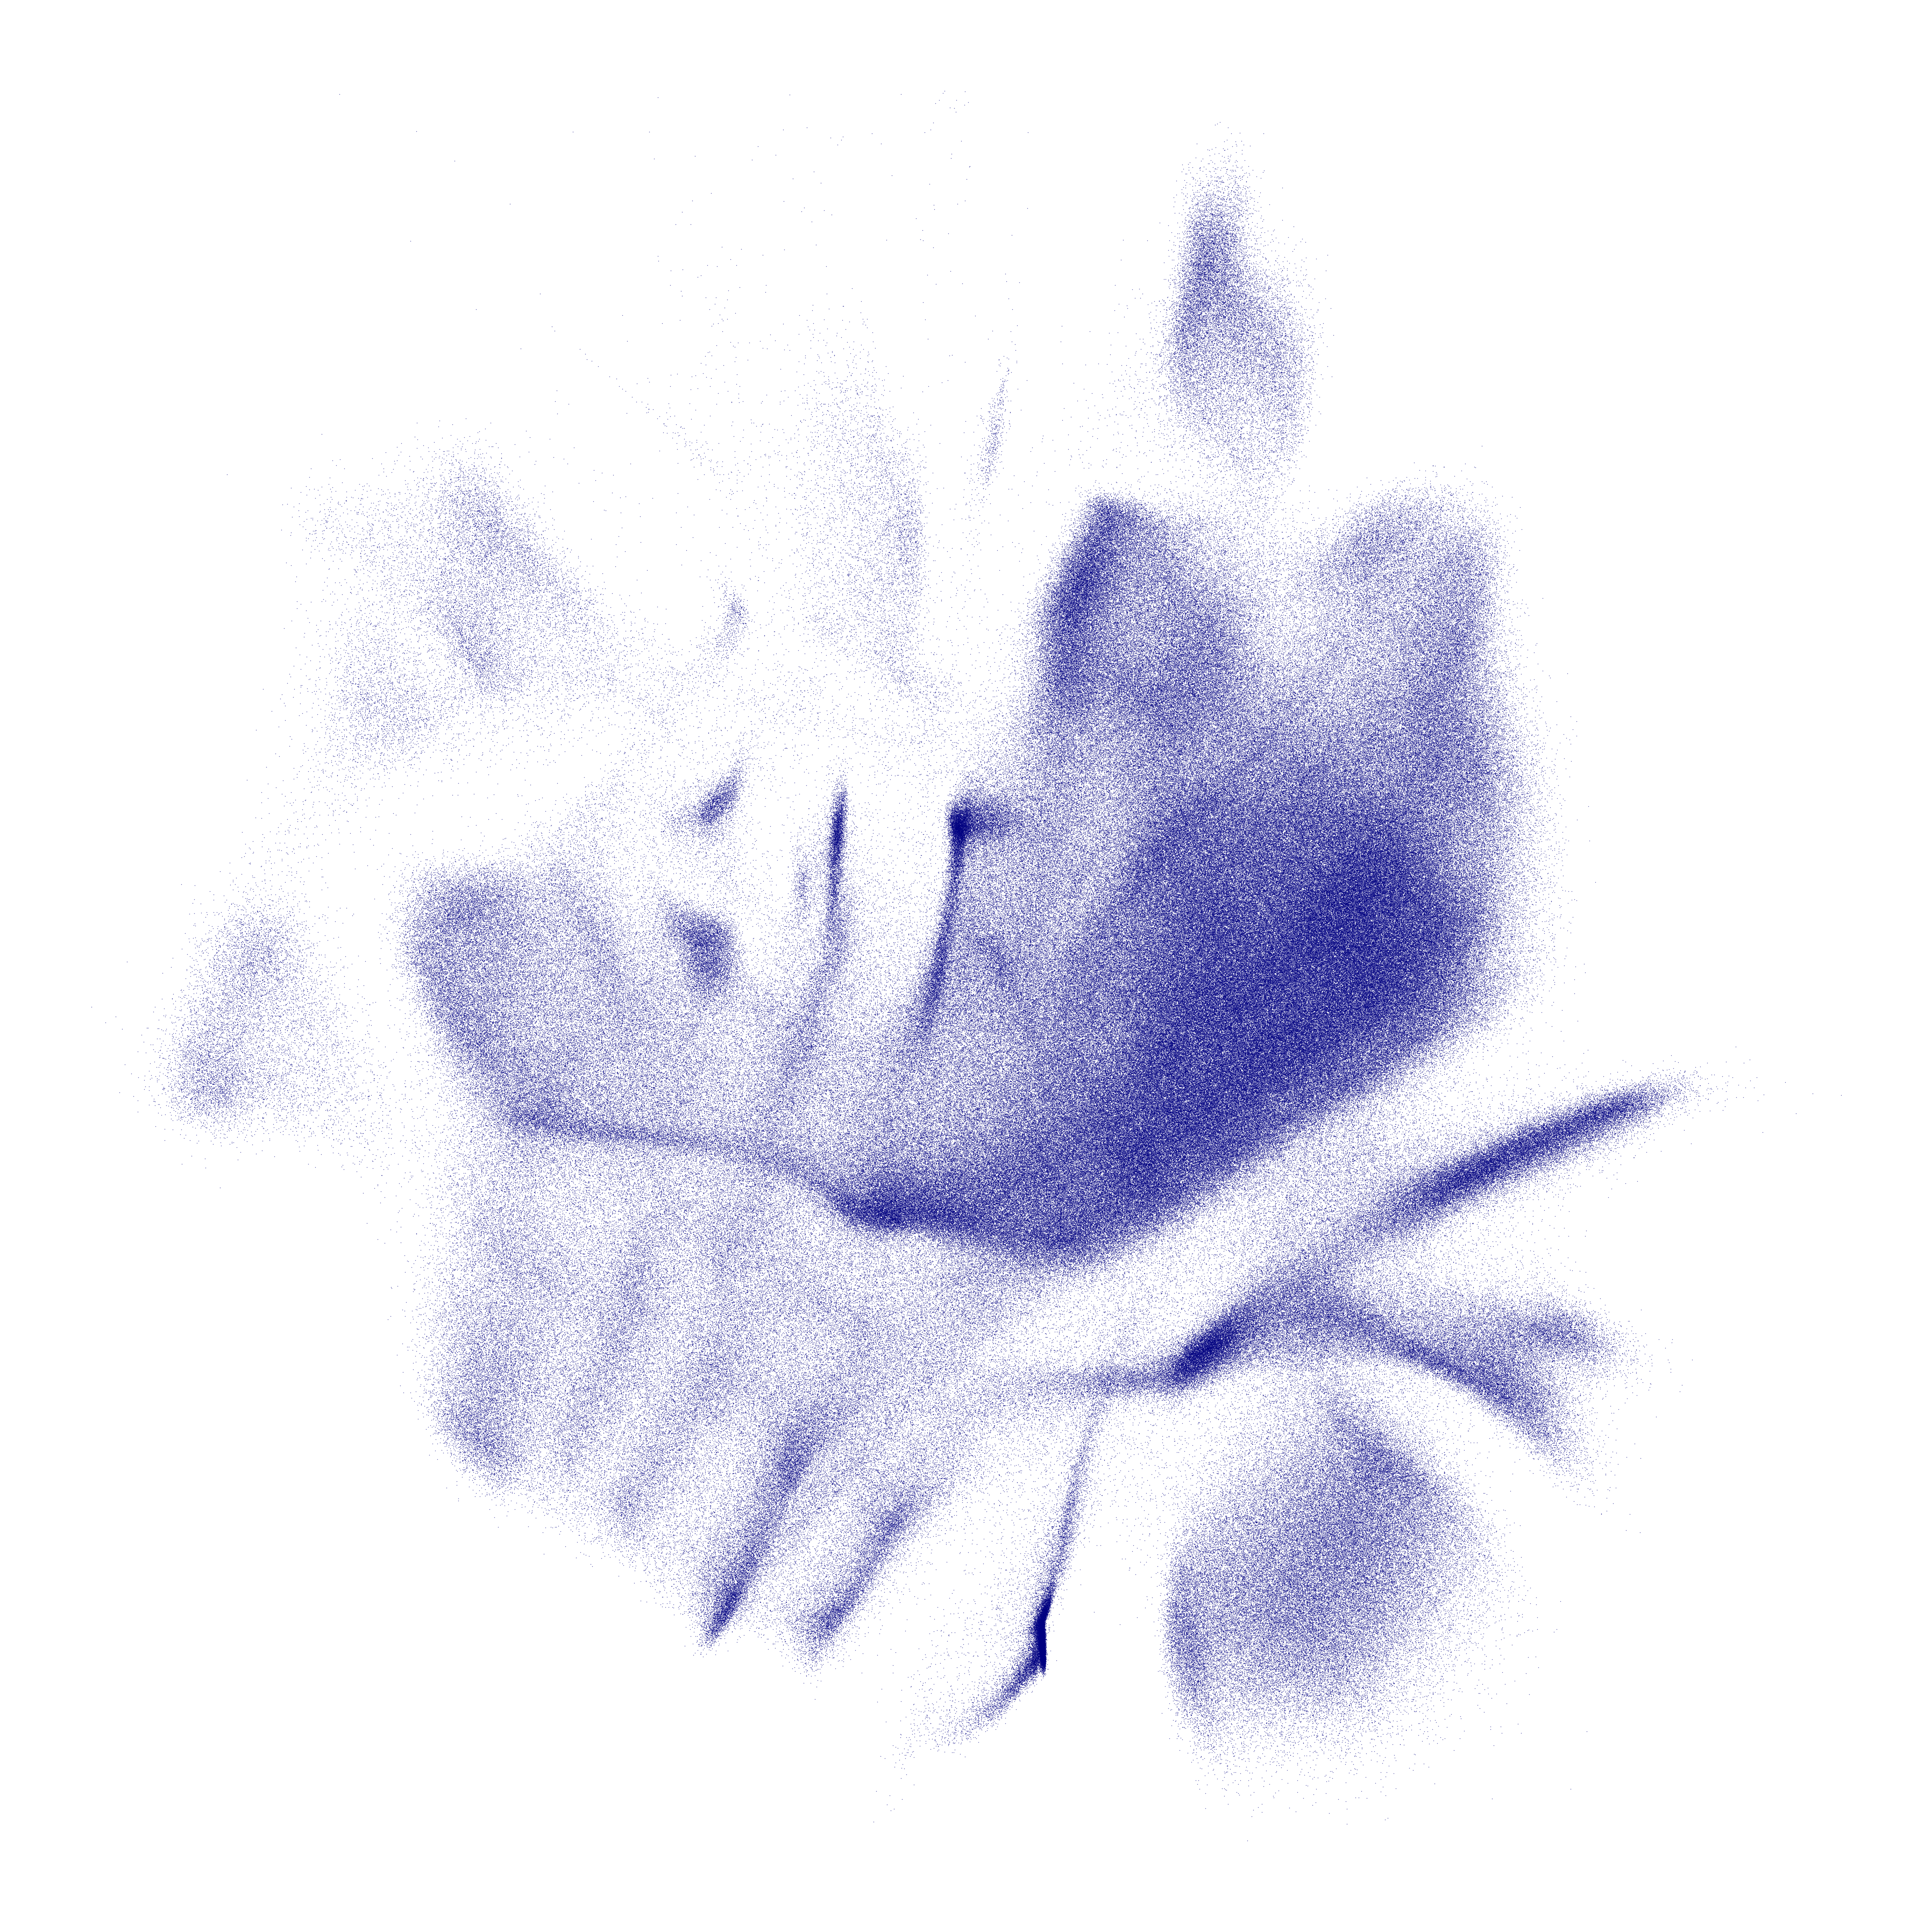

In [3]:
NEE = NeuralEE(brain_dataset, lam=1e3, device=device)
#Only pin_memory = False, not enough ram of GPU.
#Now, time mainly cost on data tranfering to GPU on each iteration.
#If ram of GPU is enough, speed could 4 times faster.
results = NEE.fine_tune(
    maxit=50, verbose=True, calculate_error=None, pin_memory=False)
# Since NeuralEE belongs to parametric metheod, it could suffer from outlier problems.
# We manually delete several outliers of embedding to make layout tighter.
embedding = results['X'].numpy()
flag = bottleneck.argpartition(-embedding[:, 1], 20)[: 20]
remain = np.ones(len(embedding), dtype=bool)
remain[flag] = False
scatter(embedding[remain], fg_kwargs={'figsize': [50, 50]}, s=0.1)